### PUI2016_fhl204 Homework 6:
https://github.com/fedhere/PUI2016_fb55/blob/master/HW6_fb55/building_nrg_instructions.ipynb

Contributors: CX, JZ, SS and FL

In [135]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import os
import json
import urllib2
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
matplotlib.style.use('ggplot')

#s = json.load( open(os.getenv('PUI2016') +'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### IDEA:
How well does the number of units in the building determine the energy consumed?
#### Null Hypothesis:
The measure of energy consumed in the building does not relate to the number of units in the building, statistical significance at p = 0.05.
#### Alternate Hypothesis:
The measure of energy consumed in the building increases proportionally to the number of units in the building, statistical significance at p = 0.05.

In [2]:
os.getenv('PUI2016')
os.getenv('PUIDATA')

'/home/cusp/fhl204/PUIdata'

In [3]:
# OPTION 1: Load JSON
url = "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.json?accessType=DOWNLOAD"

response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
data = json.loads(data)
#data

In [4]:
# OPTION 2: Load CSV
!curl -O 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
#move to PUIDATA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3110k    0 3110k    0     0  2654k      0 --:--:--  0:00:01 --:--:-- 3070k


In [87]:
nrg = gp.GeoDataFrame.from_csv("~/PUIdata/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [6]:
!curl -O 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip'
os.system('mkdir ' + os.getenv('PUIDATA') + '/mn_mappluto_16v1.zip')
os.system('mv ' + 'mn_mappluto_16v1.zip' + os.getenv('PUIDATA'))
os.system('unzip ' + os.getenv('PUIDATA') + '/mn_mappluto_16v1.zip -d' +
          os.getenv('PUIDATA') + '/mn_mappluto_16v1')
os.system('rm ' + os.getenv('PUIDATA') + '/mn_mappluto_16v1.zip')
#!unzip mn_mappluto_16v1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  5833k      0  0:00:02  0:00:02 --:--:-- 6229k


256

In [88]:
#Pluto Shape File
bsize = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + "/mn_mappluto_16v1/MNMapPLUTO.shp")
#bsize = gp.GeoDataFrame.from_file("MNMapPLUTO.shp")
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [89]:
bsize = bsize[['BBL','BldgArea','UnitsRes','UnitsTotal']]
            #'SanitBoro','SanitDist','SanitSub',\
            #'YearBuilt','ZipCode','geometry']]
bsize.columns

Index([u'BBL', u'BldgArea', u'UnitsRes', u'UnitsTotal'], dtype='object')

In [90]:
# Create new dataframe with just the columns needed
nrg = nrg[['NYC Borough, Block, and Lot (BBL)',\
            'Site EUI(kBtu/ft2)',\
            'Reported Property Floor Area (Building(s)) (ft²)',\
            'DOF Property Floor Area (Buildngs and Parking)(ft2)',\
            'DOF Number of Buildings']]
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'DOF Number of Buildings'],
      dtype='object')

In [91]:
nrg.describe()

,"NYC Borough, Block, and Lot (BBL)",DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
count,1.601400e+04,1.446500e+04,14465.000000
mean,2.240854e+09,2.022015e+05,1.901348
std,1.234669e+09,5.360972e+05,5.826292
min,1.000010e+09,5.000800e+04,1.000000
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,5.079910e+09,2.760000e+07,152.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c6b5ace10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3c6b5a63d0>]], dtype=object)

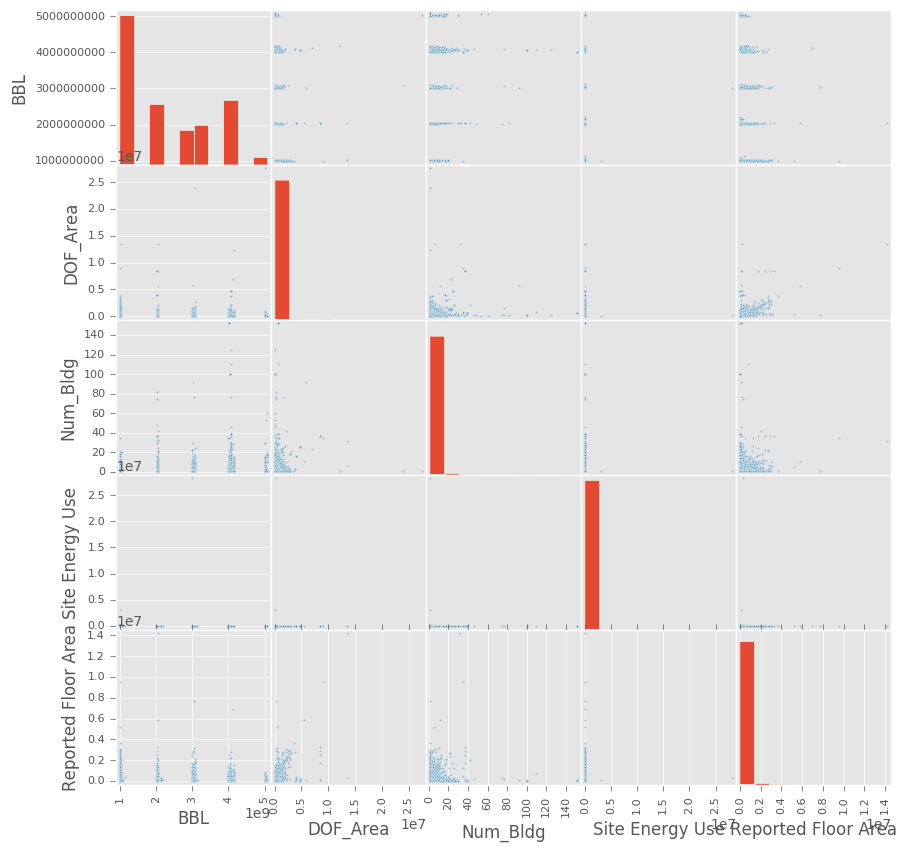

In [137]:
scatter_matrix (nrg, s=10, figsize=(10, 10))

### Figure 1: Preliminary Scatterplot of Building Dataset

#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. 

#### create a column 'BBL' 
in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: 
#### pd.merge(..... on=['BBL']) 
will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [92]:
nrg.rename(index = str, columns = {'NYC Borough, Block, and Lot (BBL)': 'BBL', \
                                   'Site EUI(kBtu/ft2)': 'Site EUI', \
                                   'Reported Property Floor Area (Building(s)) (ft²)': 'Reported_Area', \
                                   'DOF Property Floor Area (Buildngs and Parking)(ft2)': 'DOF_Area', \
                                   'DOF Number of Buildings': 'Num_Bldg'}, inplace = True)
nrg.columns

Index([u'BBL', u'Site EUI', u'Reported_Area', u'DOF_Area', u'Num_Bldg'], dtype='object')

In [94]:
# Convert data to float
nrg['Site Energy Use'] = pd.to_numeric(nrg['Site EUI'], errors='coerce')
nrg['Reported Floor Area'] = pd.to_numeric(nrg['Reported_Area'], errors='coerce')
nrg.columns

Index([u'BBL', u'Site EUI', u'Reported_Area', u'DOF_Area', u'Num_Bldg',
       u'Site Energy Use', u'Reported Floor Area'],
      dtype='object')

In [98]:
#drop old version
nrg.drop(nrg.columns[[1, 2]], axis = 1, inplace = True) 

In [99]:
#merge data
bblnrgdata = pd.merge(nrg, bsize, how = 'inner', on = 'BBL')
bblnrgdata.head()

,BBL,DOF_Area,Num_Bldg,Site Energy Use,Reported Floor Area,BldgArea,UnitsRes,UnitsTotal
0,1.006700e+09,440360.0,1.0,NaN,NaN,440360,0,1
1,1.004370e+09,52390.0,1.0,NaN,NaN,52390,0,4
2,1.013110e+09,313200.0,1.0,125.4,330000.0,313200,0,56
3,1.009220e+09,98260.0,1.0,NaN,NaN,98260,148,148
4,1.007400e+09,NaN,NaN,NaN,68329.0,48800,0,1


In [100]:
bblnrgdata.describe()

,BBL,DOF_Area,Num_Bldg,Site Energy Use,Reported Floor Area,BldgArea,UnitsRes,UnitsTotal
count,6.492000e+03,5.974000e+03,5974.000000,5.077000e+03,5.579000e+03,6.492000e+03,6492.000000,6492.000000
mean,1.012037e+09,2.217178e+05,1.275527,1.161758e+03,2.139771e+05,2.139001e+05,96.906038,108.948090
std,5.665916e+06,3.685300e+05,1.697660,4.272501e+04,3.248771e+05,3.737116e+05,248.653949,252.170956
min,1.000010e+09,5.002800e+04,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.008180e+09,NaN,NaN,NaN,NaN,6.569800e+04,0.000000,17.000000
50%,1.012344e+09,NaN,NaN,NaN,NaN,1.086070e+05,49.000000,58.000000
75%,1.015438e+09,NaN,NaN,NaN,NaN,2.120000e+05,106.250000,116.000000
max,1.022500e+09,1.343508e+07,35.000000,3.018493e+06,9.515627e+06,1.343508e+07,8759.000000,8805.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c640c8e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3c66a38f10>]], dtype=object)

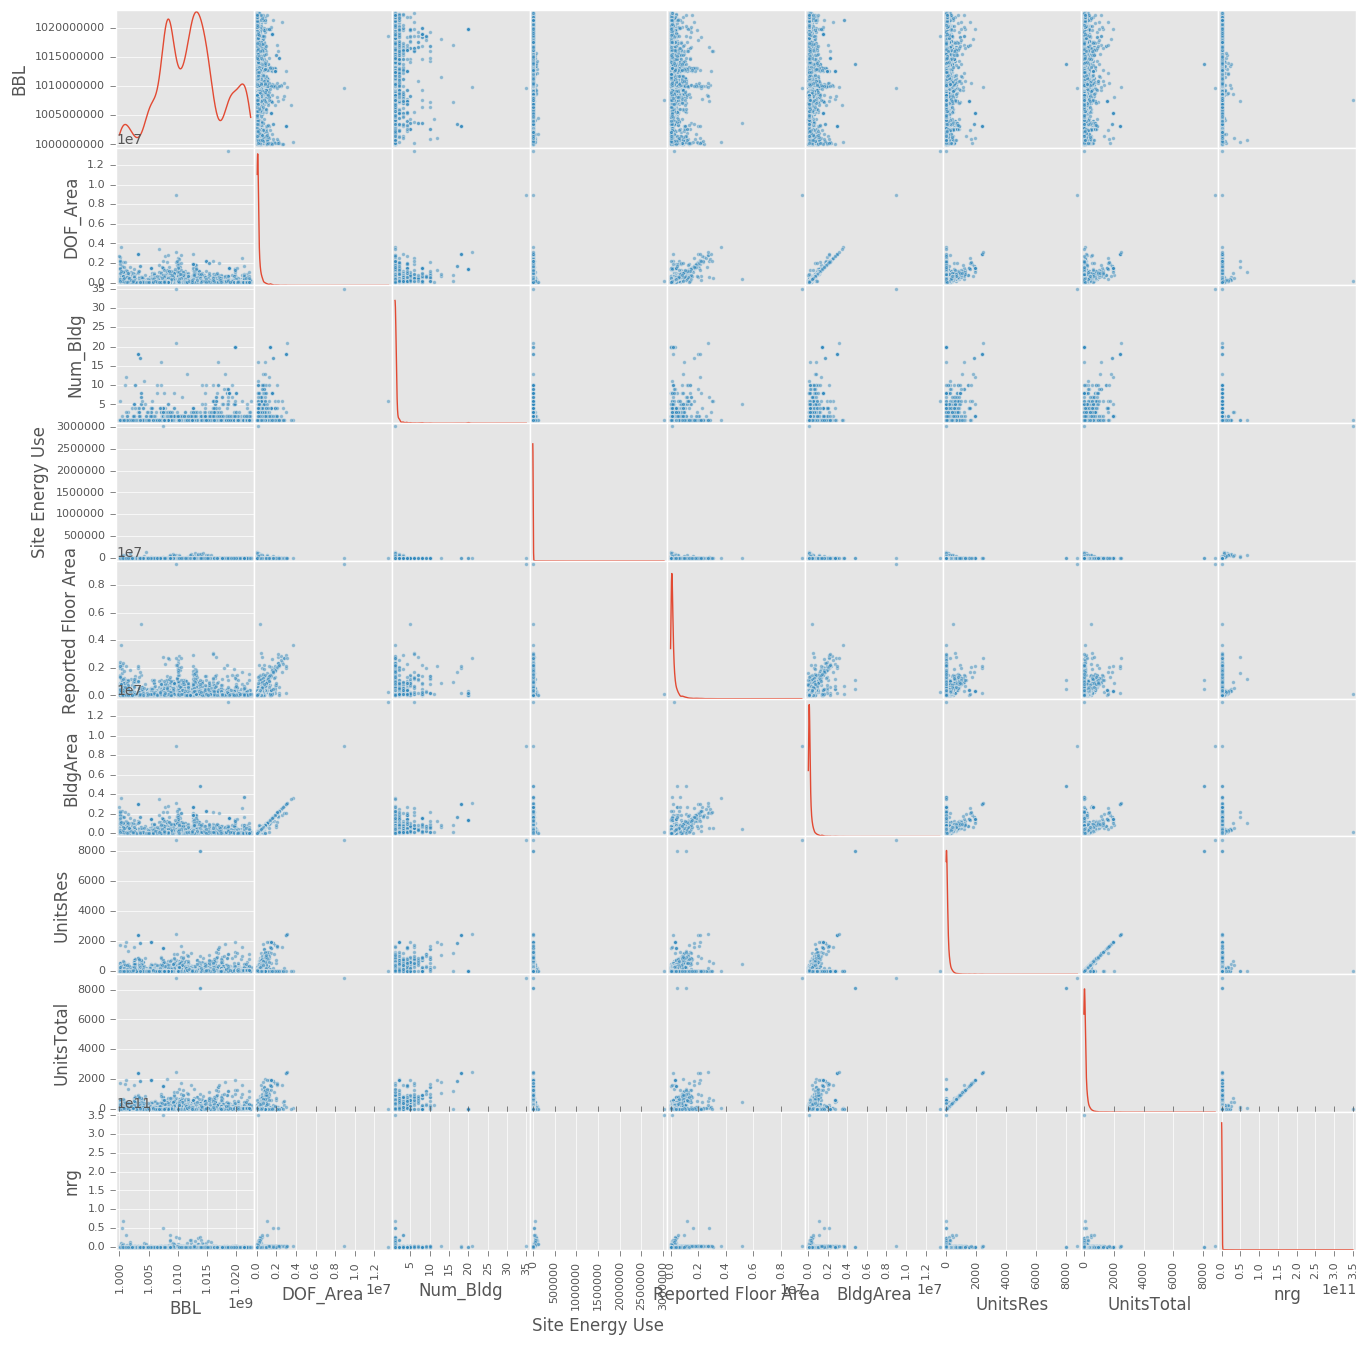

In [136]:
scatter_matrix(bblnrgdata, s = 30, figsize = (16,16), diagonal = "kde")

### Figure 2: Exploratory Scatterplot of Merged Dataset

In [104]:
# Calculate total energy use
bblnrgdata['nrg'] =  bblnrgdata['Reported Floor Area'] * bblnrgdata['Site Energy Use']
bblnrgdata['nrg'].describe()

count    5.069000e+03
mean     2.136455e+08
std      5.245490e+09
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      3.501452e+11
Name: nrg, dtype: float64

In [105]:
bblnrgdata.head()

,BBL,DOF_Area,Num_Bldg,Site Energy Use,Reported Floor Area,BldgArea,UnitsRes,UnitsTotal,nrg
0,1.006700e+09,440360.0,1.0,NaN,NaN,440360,0,1,NaN
1,1.004370e+09,52390.0,1.0,NaN,NaN,52390,0,4,NaN
2,1.013110e+09,313200.0,1.0,125.4,330000.0,313200,0,56,41382000.0
3,1.009220e+09,98260.0,1.0,NaN,NaN,98260,148,148,NaN
4,1.007400e+09,NaN,NaN,NaN,68329.0,48800,0,1,NaN


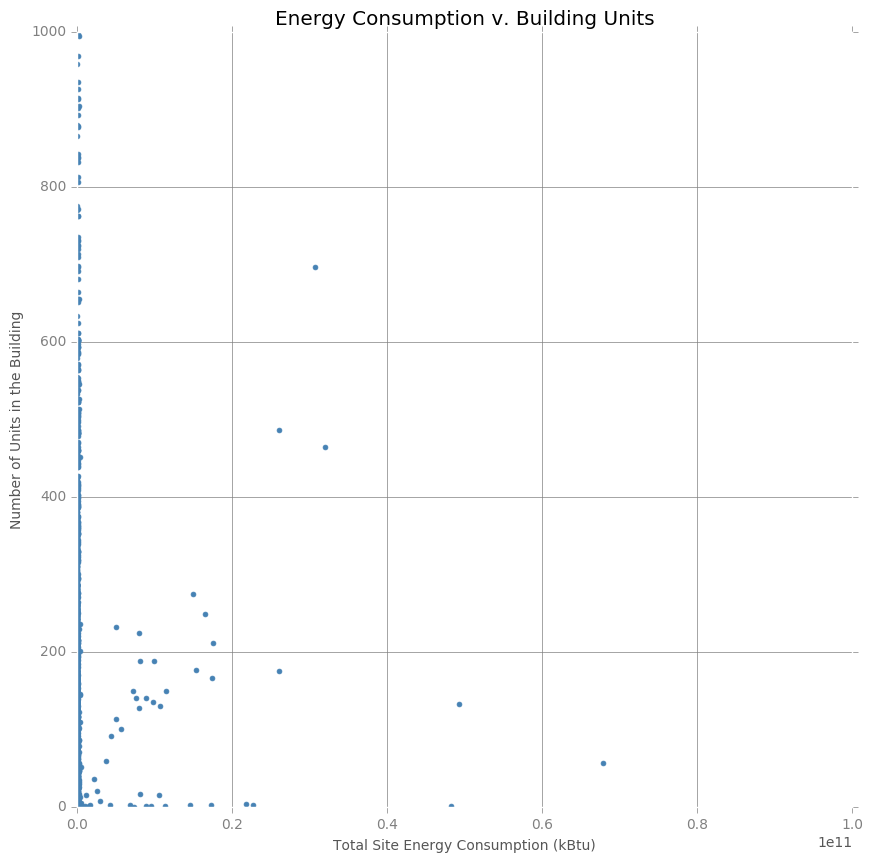

In [164]:
# Preliminary Scatter Plot at natural scale
y = bblnrgdata['UnitsTotal']
x = bblnrgdata['nrg']

fig = pl.figure(7,figsize=(10,10))
#fig.patch.set_facecolor('black')

ax = fig.add_subplot(111, axisbg='white')
ax.tick_params(color='gray', labelcolor='gray')
#for spine in ax.spines.values():
#        spine.set_edgecolor('gray')
ax.xaxis.grid(True, which="major", linestyle='-', color='gray') 
ax.yaxis.grid(True, which="major", linestyle='-', color='gray')
ax.axis([0, 1e11, 0, 1000])

ax.set_ylabel("Number of Units in the Building", fontsize=10)
ax.set_xlabel("Total Site Energy Consumption (kBtu)", fontsize=10)
plt.title('Energy Consumption v. Building Units')

ax.plot(x, y, '.', ms = 7, color = 'SteelBlue') #log plot , loglog=True

### Figure 3: Site Energy Consumption and Number of Building Units (Full Dataset)

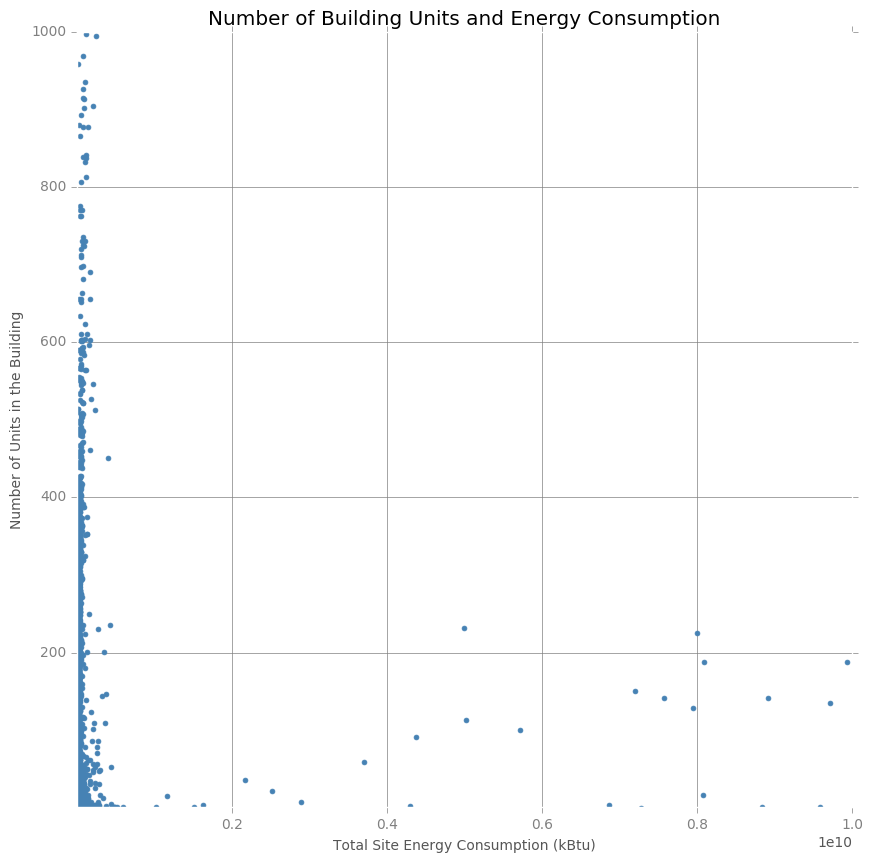

In [140]:
#Zoomed in scatter plot
y = bblnrgdata['UnitsTotal']
x = bblnrgdata['nrg']

fig = pl.figure(7,figsize=(10,10))
#fig.patch.set_facecolor('black')

ax = fig.add_subplot(111, axisbg='white')
ax.tick_params(color='gray', labelcolor='gray')
#for spine in ax.spines.values():
#        spine.set_edgecolor('gray')
ax.xaxis.grid(True, which="major", linestyle='-', color='gray') 
ax.yaxis.grid(True, which="major", linestyle='-', color='gray')
plt.axis([1000, 1e10, 1, 1000])

ax.set_ylabel("Number of Units in the Building", fontsize=10)
ax.set_xlabel("Total Site Energy Consumption (kBtu)", fontsize=10)
plt.title('Number of Building Units and Energy Consumption')

ax.plot(x, y, '.', ms = 7, color = 'SteelBlue') #log plot , loglog=True

### Figure 4: Site Energy Consumption and Number of Building Units (Zoomed In)

In [108]:
#Remove outliers and eliminate 0
bblnrgdata_cut = bblnrgdata[(bblnrgdata['nrg'] > 1000) &
                            (bblnrgdata['nrg'] < 1e10) &
                            (bblnrgdata['UnitsTotal'] > 10) & 
                            (bblnrgdata['UnitsTotal'] < 4000)]  
bblnrgdata_cut.describe()
#bblnrgdata_cut.head()

,BBL,DOF_Area,Num_Bldg,Site Energy Use,Reported Floor Area,BldgArea,UnitsRes,UnitsTotal,nrg
count,4.249000e+03,3.982000e+03,3982.000000,4249.000000,4.249000e+03,4.249000e+03,4249.000000,4249.000000,4.249000e+03
mean,1.012368e+09,1.993441e+05,1.140131,268.047658,1.988644e+05,1.926466e+05,112.252765,126.227112,4.217043e+07
std,5.471544e+06,2.661645e+05,0.877273,3299.072467,2.711212e+05,2.654671e+05,169.638598,173.510930,4.243510e+08
min,1.000048e+09,5.002900e+04,1.000000,0.100000,1.000000e+04,3.911000e+03,0.000000,11.000000,5.344000e+03
25%,1.008410e+09,NaN,NaN,65.900000,7.243700e+04,6.788200e+04,30.000000,44.000000,5.861975e+06
50%,1.012598e+09,NaN,NaN,81.900000,1.150000e+05,1.094900e+05,67.000000,75.000000,9.001181e+06
75%,1.015420e+09,NaN,NaN,100.400000,2.111070e+05,2.051490e+05,132.000000,142.000000,1.722806e+07
max,1.022500e+09,3.678000e+06,21.000000,106472.700000,5.207812e+06,3.583167e+06,2491.000000,2498.000000,9.926784e+09


(10, 1000)

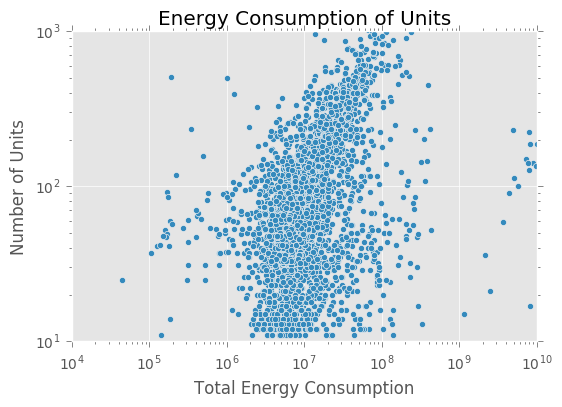

In [141]:
# Scatter plot
bblnrgdata_cut.plot.scatter(x='nrg', y='UnitsTotal', loglog=True)
pl.xlabel('Total Energy Consumption')
pl.ylabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.xlim(1e4, 1e10)
pl.ylim(10, 1000)

### Figure 5: Site Energy Consumption and Building Units (Outliers removed and variables logged)

(10, 1000)

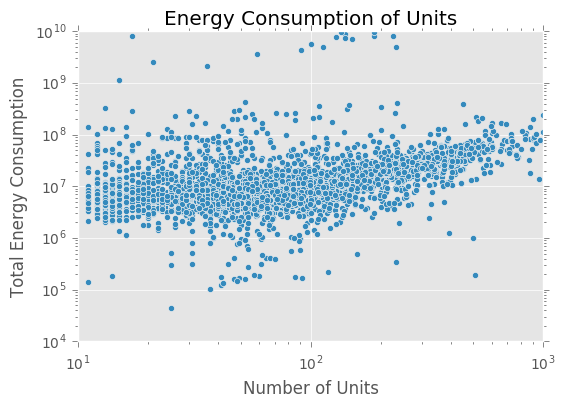

In [142]:
# Rotate axis
bblnrgdata_cut.plot.scatter(x='UnitsTotal', y='nrg', loglog=True)
pl.ylabel('Total Energy Consumption')
pl.xlabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.ylim(1e4, 1e10)
pl.xlim(10, 1000)

### Figure 6: Building Units and Site Energy Consumption (Outliers removed and variables logged)

Chi-square Energy vs Unit is 925.453192114: 


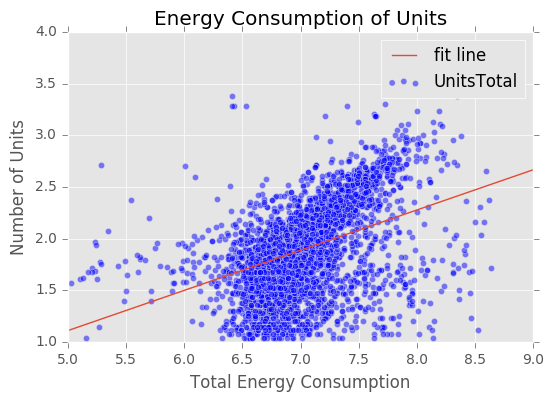

In [162]:
# Fit line
x = bblnrgdata_cut['nrg']
y = bblnrgdata_cut['UnitsTotal']
X = sm.add_constant(np.log10(x))
model= sm.OLS(np.log10(y), X, missing='drop').fit()
model_Y = model.predict()
observed_y = np.log10(y)
error = observed_y / 2
chisq = ((model_Y - observed_y)**2 / (error**2)).sum()
print ("Chi-square Energy vs Unit is %s: " %chisq)
pl.scatter(log10(x), log10(y), alpha=0.5)
x_fit = np.linspace(5, 10, 1000)
X_fit = sm.add_constant(x_fit)
plot(x_fit, model.predict(X_fit), label='fit line')

pl.xlabel('Total Energy Consumption')
pl.ylabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.ylim(1, 4)
pl.xlim(5,9)
pl.legend(loc='best')

### Figure 7: Site Energy Consumption and Building Units with Line Fit 

In [145]:
DOF = len(bblnrgdata_cut) - 2 - 1 # DOF = degree of freedom
print ("Goodness of fit for Chi-square: ", chisq / DOF)

Goodness of fit for Chi-square:  0.217958829985


In [146]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     971.6
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          2.89e-192
Time:                        17:48:57   Log-Likelihood:                -1729.7
No. Observations:                4249   AIC:                             3463.
Df Residuals:                    4247   BIC:                             3476.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.8335      0.088     -9.494      0.000        -1.006    -0.661
nrg            0.3888      0.012     31.170      0.000         0.364     0.413
==============================================================================
Omnibus:                      139.667   Durbin-Watson:                   1.341
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.344
Skew:                          -0.345   Prob(JB):                     6.29e-43
Kurtosis:                       3.788   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
y = bblnrgdata_cut['nrg']
x = bblnrgdata_cut['UnitsTotal']

In [148]:
X = sm.add_constant(np.log10(x))
model= sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires where x or y is NaN

In [149]:
model_Y = model.predict()
observed_y = np.log10(y)
error = observed_y / 2
chisq = ((model_Y - observed_y)**2 / (error**2)).sum()
print ("Chi-square Energy vs Unit is %s: " %chisq)

Chi-square Energy vs Unit is 56.2067006722: 


In [150]:
DOF = len(bblnrgdata_cut) - 2 - 1 # DOF = degree of freedom
print ("Goodness of fit for Chi-square: ", chisq / DOF)

Goodness of fit for Chi-square:  0.0132375649252


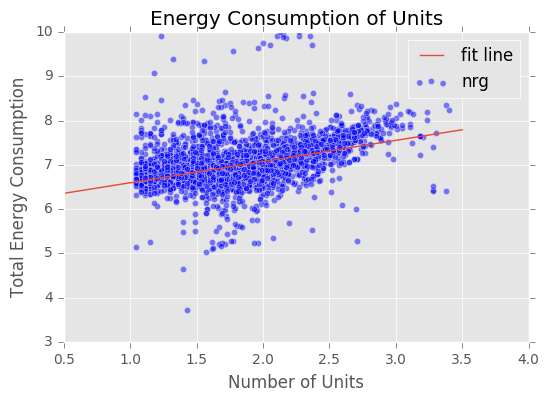

In [151]:
pl.scatter(log10(x), log10(y), alpha=0.5)
x_fit = np.linspace(0.5, 3.5, 1000)
X_fit = sm.add_constant(x_fit)
plot(x_fit, model.predict(X_fit), label='fit line')

pl.ylabel('Total Energy Consumption')
pl.xlabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.xlim(0.5, 4)
pl.ylim(3,10)
pl.legend(loc='best')

### Figure 8: Building Units and Site Energy Consumption with Line Fit

In [128]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     971.6
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          2.89e-192
Time:                        17:44:38   Log-Likelihood:                -2172.3
No. Observations:                4249   AIC:                             4349.
Df Residuals:                    4247   BIC:                             4361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1155      0.030    205.218      0.000         6.057     6.174
UnitsTotal     0.4789      0.015     31.170      0.000         0.449     0.509
==============================================================================
Omnibus:                     1464.081   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23029.844
Skew:                           1.213   Prob(JB):                         0.00
Kurtosis:                      14.144   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

the goodness of fit of chi-square test tells the units vs energy is better

In [166]:
# Polyfit - second degree curve
polyfit = pd.DataFrame()
polyfit['X'] = np.log10(bblnrgdata_cut['UnitsTotal'])
polyfit['Y'] = np.log10(bblnrgdata_cut['nrg'])
polyfit['X2'] = np.log10(bblnrgdata_cut['UnitsTotal'])**2

In [153]:
polyfit.head()

,X,Y,X2
2,1.748188,7.616811,3.056161
16,1.380211,7.629287,1.904983
18,1.380211,7.286094,1.904983
19,1.792392,6.950549,3.212668
20,1.929419,6.811909,3.722657


In [154]:
poly2 = smf.ols(formula = 'Y ~ X2 + X', data=polyfit).fit()
poly2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     643.0
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          1.12e-244
Time:                        17:49:18   Log-Likelihood:                -2047.9
No. Observations:                4249   AIC:                             4102.
Df Residuals:                    4246   BIC:                             4121.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.6307      0.099     77.073      0.000         7.437     7.825
X2             0.4160      0.026     16.004      0.000         0.365     0.467
X             -1.1446      0.103    -11.163      0.000        -1.346    -0.944
==============================================================================
Omnibus:                     1492.582   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31898.004
Skew:                           1.154   Prob(JB):                         0.00
Kurtosis:                      16.223   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
polyfit2 = polyfit[['X2', 'X']]
polyfit2.head()

,X2,X
2,3.056161,1.748188
16,1.904983,1.380211
18,1.904983,1.380211
19,3.212668,1.792392
20,3.722657,1.929419


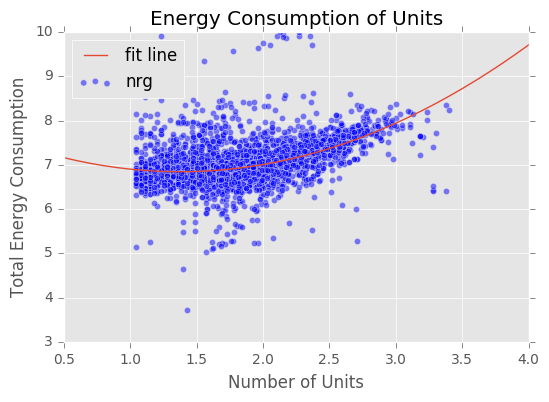

In [159]:
pl.scatter(log10(x), log10(y), alpha=0.5)
polyfit2 = pd.DataFrame()
polyfit2['X'] = np.arange(0.5, 4.5, 0.1)
polyfit2['X2'] = polyfit2['X']**2
plot(polyfit2['X'], poly2.predict(polyfit2), label='fit line')

pl.ylabel('Total Energy Consumption')
pl.xlabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.xlim(0.5, 4)
pl.ylim(3,10)
pl.legend(loc='best')

### Figure 9: Site Energy Consumption of Building Units with Polyfit Line 

In [161]:
print ("LR : ", -2 * (model.llf - poly2.llf))
print ("LR from statsmodels:", poly2.compare_lr_test(model))

LR :  248.862430714
LR from statsmodels: (248.86243071410263, 4.59665871757881e-56, 1.0)


For degree of freedom 1 and significance level 0.05, critical value is 3.84. LR is larger than 3.84, therefore we can reject null hypothesis that linear model is better fit for data than polynomial 2nd degree model